# Air BnB, Hotels.com and Booking.com Analysis

## Introduction

I want to explore factors that can help us get the most out of our holiday accomodation. The ultimate goal of this analysis is to find out what factors are the major contributers to overall satisfaction. This notebook will include cleaning, EDA and advanced analysis. Even though satisfaction has a lot of subjective influence, the hope is to find that there are factors that may avoid or shine through the subjectiveness of satisfaction. 

## Data Description

The data was obtained from Kaggle (https://www.kaggle.com/datasets/mykhailozub/500-hotels-from-airbnb-booking-and-hotelscom?select=Berlin.json). 
This was taken from the description: 

"This dataset was created while I was working on a SerpApi demo project to showcase hotels-scraper-js NPM tool.

This dataset includes only hotel listings from Airbnb, Booking, and Hotels.com, and the main point was to explore prices in famous European capitals. 500 hotels from each website per city.

In total, there're 7500 hotel listings."

There are 3 different arrays present in the json file which represent the 3 different websites (AirBnB. Hotels.com and Booking.com) used to gather the data. Below I will start the process of showing what is inside the dataset and then performing some cleaning techniques to refine the data.

## Steps for Cleaning

### Import Packages

In [131]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sns
from scipy.stats import zscore
from scipy.stats import shapiro
import statsmodels.api as sm
from scipy import stats
import math
from sklearn.linear_model import LinearRegression
from itertools import zip_longest
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as mc
from scipy.optimize import curve_fit
from sklearn.feature_selection import f_regression
import scikit_posthocs as sp # might have to pip install 'scikit_posthocs'
from scipy.stats import skew, kurtosis

### Inspect json files for different array names

In [2]:
# Open the JSON file
with open('Berlin.json', encoding="utf8") as f:
    # Load the JSON data
    data = json.load(f)

# Find the names of all the arrays
array_names = []
for key, value in data.items():
    if isinstance(value, list):
        array_names.append(key)

# Print the array names
print('Arrays found in json files:\n')
for name in array_names:
    print(name)

Arrays found in json files:

airbnbHotels
bookingHotels
hotelsComHotels


### Take array names and open each seperately as each have different information

#### AirBnb

In [3]:
# created a function to open json files and then store them into a dictionary 
def file_opener_abnb(files):
    data_dict = {}

    for file in files:
        # Opening JSON file
        with open(file, encoding="utf8") as f:
            # Load JSON object as a dictionary
            data = json.load(f)

        # Store the "airbnbHotels" data in a list
        file_list = [item for item in data["airbnbHotels"]]

        # Add the list to the dictionary with the file name as the key
        data_dict[file] = file_list
    
    return data_dict

files = ['Berlin.json', 'Paris.json', 'Rome.json', 'London.json', 'Madrid.json']

result_abnb = file_opener_abnb(files)

In [4]:
berlin_df_abnb = pd.DataFrame(result_abnb['Berlin.json'])
berlin_df_abnb.head()

,thumbnail,title,subtitles,price,rating,link
0,https://a0.muscache.com/im/pictures/miso/Hosti...,Private room in Tempelhof,"[Privatzimmer in Tempelhofer Feld, 1 bed, Jul ...","{'currency': '$', 'value': 31, 'period': 'night'}",5,https://www.airbnb.com/rooms/647664199858827562
1,https://a0.muscache.com/im/pictures/b9cb8b8c-5...,Private room in Mitte,"[Tiny, individual Room with private Bathroom, ...","{'currency': '$', 'value': 40, 'period': 'night'}",4.96,https://www.airbnb.com/rooms/41220512
2,https://a0.muscache.com/im/pictures/miso/Hosti...,Hotel room in Prenzlauer Berg,[Serviced Apartment - Studio in Prenzlauer Ber...,"{'currency': '$', 'value': 108, 'period': 'nig...",4.69,https://www.airbnb.com/rooms/30881310
3,https://a0.muscache.com/im/pictures/63522495/a...,Private room in Lichtenberg,"[City East perfectly located, 1 king bed, Jul ...","{'currency': '$', 'value': 34, 'period': 'night'}",4.89,https://www.airbnb.com/rooms/2591901
4,https://a0.muscache.com/im/pictures/miso/Hosti...,Private room in Charlottenburg-Wilmersdorf,[Musical place next to Bundesplatz (U9 & S-Rin...,"{'currency': '$', 'value': 71, 'period': 'night'}",4.87,https://www.airbnb.com/rooms/19075304


#### Booking.com

In [5]:
# created a function to open json files and then store them into a dictionary
def file_opener_book(files):
    data_dict = {}

    for file in files:
        # Opening JSON file
        with open(file, encoding="utf8") as f:
            # Load JSON object as a dictionary
            data = json.load(f)

        # Store the "airbnbHotels" data in a list
        file_list = [item for item in data["bookingHotels"]]

        # Add the list to the dictionary with the file name as the key
        data_dict[file] = file_list

    return data_dict

files = ['Berlin.json', 'Paris.json', 'Rome.json', 'London.json', 'Madrid.json']

result_book = file_opener_book(files)

In [6]:
berlin_df_book = pd.DataFrame(result_book['Berlin.json'])
berlin_df_book.head()

,thumbnail,title,stars,preferredBadge,promotedBadge,location,subwayAccess,sustainability,distanceFromCenter,highlights,price,rating,link
0,https://cf.bstatic.com/xdata/images/hotel/squa...,Scandic Berlin Kurfürstendamm,NaN,True,True,"Charlottenburg-Wilmersdorf, Berlin",True,Travel Sustainable property,3.2,"[Standard Double Room, Beds: 1 double or 2 twi...","{'currency': 'US$', 'value': 111, 'taxesAndCha...","{'score': 8.1, 'scoreDescription': 'Very Good'...",https://www.booking.com/hotel/de/scandic-kurfu...
1,https://cf.bstatic.com/xdata/images/hotel/squa...,Hotel Karlshorst,3.0,False,False,"Lichtenberg, Berlin",False,NaN,10.7,"[Comfort Double Room, Beds: 1 double or 2 twin...","{'currency': 'US$', 'value': 68, 'taxesAndChar...","{'score': 6.8, 'scoreDescription': 'Review sco...",https://www.booking.com/hotel/de/thang-long-re...
2,https://cf.bstatic.com/xdata/images/hotel/squa...,Jugendherberge Berlin Ostkreuz,3.0,False,False,"Lichtenberg, Berlin",False,NaN,6.5,"[Triple Room, 3 beds (1 twin, 2 bunk beds)]","{'currency': 'US$', 'value': 104, 'taxesAndCha...","{'score': 8.4, 'scoreDescription': 'Very Good'...",https://www.booking.com/hotel/de/jugendherberg...
3,https://cf.bstatic.com/xdata/images/hotel/squa...,Hollywood Media Hotel am Kurfürstendamm,4.0,True,False,"Charlottenburg-Wilmersdorf, Berlin",True,Travel Sustainable property,4.1,"[Standard Double or Twin Room, Beds: 1 double ...","{'currency': 'US$', 'value': 100, 'taxesAndCha...","{'score': 8.3, 'scoreDescription': 'Very Good'...",https://www.booking.com/hotel/de/hollywood-med...
4,https://cf.bstatic.com/xdata/images/hotel/squa...,Meliá Berlin,4.0,True,True,"Mitte, Berlin",True,Travel Sustainable property,1.0,"[Melia Room, Multiple bed types, Only 1 room l...","{'currency': 'US$', 'value': 135, 'taxesAndCha...","{'score': 8.3, 'scoreDescription': 'Very Good'...",https://www.booking.com/hotel/de/melia-berlin....


#### Hotels.com

In [7]:
# created a function to open json files and then store them into a dictionary
def file_opener_com(files):
    data_dict = {}

    for file in files:
        # Opening JSON file
        with open(file, encoding="utf8") as f:
            # Load JSON object as a dictionary
            data = json.load(f)

        # Store the "airbnbHotels" data in a list
        file_list = [item for item in data["hotelsComHotels"]]

        # Add the list to the dictionary with the file name as the key
        data_dict[file] = file_list

    return data_dict

files = ['Berlin.json', 'Paris.json', 'Rome.json', 'London.json', 'Madrid.json']

result_com = file_opener_com(files)

In [8]:
berlin_df_com = pd.DataFrame(result_com['Berlin.json'])
berlin_df_com.head()

,title,isAd,location,snippet,paymentOptions,highlightedAmenities,price,rating,link
0,Moxy Berlin Ostbahnhof,True,Friedrichshain,{'title': 'Lifestyle Hotel close to Ostbahnhof...,[],[],"{'currency': '$', 'value': 107, 'withTaxesAndC...","{'score': 8.8, 'reviews': 596}",https://www.hotels.com/ho497828896/moxy-berlin...
1,Sheraton Berlin Grand Hotel Esplanade,True,Tiergarten,{'title': 'Berlin hotel with panoramic windows...,[],[],"{'currency': '$', 'value': 163, 'withTaxesAndC...","{'score': 8.6, 'reviews': 1000}",https://www.hotels.com/ho109823/sheraton-berli...
2,IntercityHotel Berlin Ostbahnhof,False,Friedrichshain,{},[],[],"{'currency': '$', 'value': 93, 'withTaxesAndCh...","{'score': 8.4, 'reviews': 1005}",https://www.hotels.com/ho178251/intercityhotel...
3,URBAN LOFT Berlin,False,Berlin,{},[],[],"{'currency': '$', 'value': 86, 'withTaxesAndCh...","{'score': 9, 'reviews': 154}",https://www.hotels.com/ho2505665600/urban-loft...
4,Dorint Kurfürstendamm Berlin,False,Berlin,{},"[Fully refundable, Reserve now, pay later]",[],"{'currency': '$', 'value': 148, 'withTaxesAndC...","{'score': 9.2, 'reviews': 1006}",https://www.hotels.com/ho185137/dorint-kurfurs...


#### Compare heading names

In [9]:
hotel_columns = berlin_df_com.columns
book_columns = berlin_df_book.columns
abnb_columns = berlin_df_abnb.columns

hot_col_list = []
for column in hotel_columns:
    hot_col_list.append(column)

book_col_list = []
for column in book_columns:
    book_col_list.append(column)
    

abnb_col_list = []
for column in abnb_columns:
    abnb_col_list.append(column)
print("Column Comparison:")
print()
print("Columns in Hotels.com Data:")
print(hot_col_list)
print()
print("Columns in Booking.com Data:")
print(book_col_list)
print()
print("Columns in Airbnb Data:")
print(abnb_col_list)

Column Comparison:

Columns in Hotels.com Data:
['title', 'isAd', 'location', 'snippet', 'paymentOptions', 'highlightedAmenities', 'price', 'rating', 'link']

Columns in Booking.com Data:
['thumbnail', 'title', 'stars', 'preferredBadge', 'promotedBadge', 'location', 'subwayAccess', 'sustainability', 'distanceFromCenter', 'highlights', 'price', 'rating', 'link']

Columns in Airbnb Data:
['thumbnail', 'title', 'subtitles', 'price', 'rating', 'link']


### Create the other dataframes

In [10]:
# Rome
rome_df_com = pd.DataFrame(result_com['Rome.json'])
rome_df_book = pd.DataFrame(result_book['Rome.json'])
rome_df_abnb = pd.DataFrame(result_abnb['Rome.json'])

# Madrid
madrid_df_com = pd.DataFrame(result_com['Madrid.json'])
madrid_df_book = pd.DataFrame(result_book['Madrid.json'])
madrid_df_abnb = pd.DataFrame(result_abnb['Madrid.json'])

# Paris
paris_df_com = pd.DataFrame(result_com['Paris.json'])
paris_df_book = pd.DataFrame(result_book['Paris.json'])
paris_df_abnb = pd.DataFrame(result_abnb['Paris.json'])

# London
london_df_com = pd.DataFrame(result_com['London.json'])
london_df_book = pd.DataFrame(result_book['London.json'])
london_df_abnb = pd.DataFrame(result_abnb['London.json'])

### Add a 'City' column

In [11]:
# add the city name for each before we join

# London
london_df_abnb = london_df_abnb.assign(city = 'London')
london_df_book = london_df_book.assign(city = 'London')
london_df_com = london_df_com.assign(city = 'London')

# Paris
paris_df_abnb = paris_df_abnb.assign(city = 'Paris')
paris_df_book = paris_df_book.assign(city = 'Paris')
paris_df_com = paris_df_com.assign(city = 'Paris')

# Berlin
berlin_df_abnb = berlin_df_abnb.assign(city = 'Berlin')
berlin_df_book = berlin_df_book.assign(city = 'Berlin')
berlin_df_com = berlin_df_com.assign(city = 'Berlin')

# Rome
rome_df_abnb = rome_df_abnb.assign(city = 'Rome')
rome_df_book = rome_df_book.assign(city = 'Rome')
rome_df_com = rome_df_com.assign(city = 'Rome')

# Madrid
madrid_df_abnb = madrid_df_abnb.assign(city = 'Madrid')
madrid_df_book = madrid_df_book.assign(city = 'Madrid')
madrid_df_com = madrid_df_com.assign(city = 'Madrid')

### Create a seperate dataframes for the different sites

#### Booking.com

In [12]:
booking_df = pd.concat([berlin_df_book, paris_df_book, london_df_book, rome_df_book, madrid_df_book], ignore_index=True)
booking_df.head()

,thumbnail,title,stars,preferredBadge,promotedBadge,location,subwayAccess,sustainability,distanceFromCenter,highlights,price,rating,link,city
0,https://cf.bstatic.com/xdata/images/hotel/squa...,Scandic Berlin Kurfürstendamm,NaN,True,True,"Charlottenburg-Wilmersdorf, Berlin",True,Travel Sustainable property,3.2,"[Standard Double Room, Beds: 1 double or 2 twi...","{'currency': 'US$', 'value': 111, 'taxesAndCha...","{'score': 8.1, 'scoreDescription': 'Very Good'...",https://www.booking.com/hotel/de/scandic-kurfu...,Berlin
1,https://cf.bstatic.com/xdata/images/hotel/squa...,Hotel Karlshorst,3.0,False,False,"Lichtenberg, Berlin",False,NaN,10.7,"[Comfort Double Room, Beds: 1 double or 2 twin...","{'currency': 'US$', 'value': 68, 'taxesAndChar...","{'score': 6.8, 'scoreDescription': 'Review sco...",https://www.booking.com/hotel/de/thang-long-re...,Berlin
2,https://cf.bstatic.com/xdata/images/hotel/squa...,Jugendherberge Berlin Ostkreuz,3.0,False,False,"Lichtenberg, Berlin",False,NaN,6.5,"[Triple Room, 3 beds (1 twin, 2 bunk beds)]","{'currency': 'US$', 'value': 104, 'taxesAndCha...","{'score': 8.4, 'scoreDescription': 'Very Good'...",https://www.booking.com/hotel/de/jugendherberg...,Berlin
3,https://cf.bstatic.com/xdata/images/hotel/squa...,Hollywood Media Hotel am Kurfürstendamm,4.0,True,False,"Charlottenburg-Wilmersdorf, Berlin",True,Travel Sustainable property,4.1,"[Standard Double or Twin Room, Beds: 1 double ...","{'currency': 'US$', 'value': 100, 'taxesAndCha...","{'score': 8.3, 'scoreDescription': 'Very Good'...",https://www.booking.com/hotel/de/hollywood-med...,Berlin
4,https://cf.bstatic.com/xdata/images/hotel/squa...,Meliá Berlin,4.0,True,True,"Mitte, Berlin",True,Travel Sustainable property,1.0,"[Melia Room, Multiple bed types, Only 1 room l...","{'currency': 'US$', 'value': 135, 'taxesAndCha...","{'score': 8.3, 'scoreDescription': 'Very Good'...",https://www.booking.com/hotel/de/melia-berlin....,Berlin


In [13]:
print('Initial Shape of Booking.com Dataframe:\n')
print(booking_df.shape)

Initial Shape of Booking.com Dataframe:

(2208, 14)


##### Create new columns for price and rating

In [14]:
# Create copy of df
new_booking_df = booking_df.copy()
# Take the price value from the price column into a new column called price_value
new_booking_df['price_value'] = new_booking_df['price'].apply(lambda x: x['value'])

# Take the rating value from the rating column into a new column called rating_score
new_booking_df['rating_score'] = new_booking_df['rating'].apply(lambda x: x['score'])

new_booking_df.head()

,thumbnail,title,stars,preferredBadge,promotedBadge,location,subwayAccess,sustainability,distanceFromCenter,highlights,price,rating,link,city,price_value,rating_score
0,https://cf.bstatic.com/xdata/images/hotel/squa...,Scandic Berlin Kurfürstendamm,NaN,True,True,"Charlottenburg-Wilmersdorf, Berlin",True,Travel Sustainable property,3.2,"[Standard Double Room, Beds: 1 double or 2 twi...","{'currency': 'US$', 'value': 111, 'taxesAndCha...","{'score': 8.1, 'scoreDescription': 'Very Good'...",https://www.booking.com/hotel/de/scandic-kurfu...,Berlin,111,8.1
1,https://cf.bstatic.com/xdata/images/hotel/squa...,Hotel Karlshorst,3.0,False,False,"Lichtenberg, Berlin",False,NaN,10.7,"[Comfort Double Room, Beds: 1 double or 2 twin...","{'currency': 'US$', 'value': 68, 'taxesAndChar...","{'score': 6.8, 'scoreDescription': 'Review sco...",https://www.booking.com/hotel/de/thang-long-re...,Berlin,68,6.8
2,https://cf.bstatic.com/xdata/images/hotel/squa...,Jugendherberge Berlin Ostkreuz,3.0,False,False,"Lichtenberg, Berlin",False,NaN,6.5,"[Triple Room, 3 beds (1 twin, 2 bunk beds)]","{'currency': 'US$', 'value': 104, 'taxesAndCha...","{'score': 8.4, 'scoreDescription': 'Very Good'...",https://www.booking.com/hotel/de/jugendherberg...,Berlin,104,8.4
3,https://cf.bstatic.com/xdata/images/hotel/squa...,Hollywood Media Hotel am Kurfürstendamm,4.0,True,False,"Charlottenburg-Wilmersdorf, Berlin",True,Travel Sustainable property,4.1,"[Standard Double or Twin Room, Beds: 1 double ...","{'currency': 'US$', 'value': 100, 'taxesAndCha...","{'score': 8.3, 'scoreDescription': 'Very Good'...",https://www.booking.com/hotel/de/hollywood-med...,Berlin,100,8.3
4,https://cf.bstatic.com/xdata/images/hotel/squa...,Meliá Berlin,4.0,True,True,"Mitte, Berlin",True,Travel Sustainable property,1.0,"[Melia Room, Multiple bed types, Only 1 room l...","{'currency': 'US$', 'value': 135, 'taxesAndCha...","{'score': 8.3, 'scoreDescription': 'Very Good'...",https://www.booking.com/hotel/de/melia-berlin....,Berlin,135,8.3


##### Create a new dataframe by removing columns

In [15]:
# Drop irrelevant columns
merge_booking_df = new_booking_df.drop(columns = ['thumbnail','title','stars','distanceFromCenter', 'preferredBadge','promotedBadge','location',
                                                    'subwayAccess','sustainability','highlights','price','rating','link'])
merge_booking_df.head()

,city,price_value,rating_score
0,Berlin,111,8.1
1,Berlin,68,6.8
2,Berlin,104,8.4
3,Berlin,100,8.3
4,Berlin,135,8.3


##### Check values in columns, remove Nan values, change data types

In [16]:
# Check if there are any non-numeric values
book_price_value_dtype = merge_booking_df['price_value'].dtype
book_rating_score_dtype = merge_booking_df['rating_score'].dtype

print('Data types of the columns in Booking.com Table:\n')
print(f'price_value: {book_price_value_dtype}\nrating_score: {book_rating_score_dtype}')

Data types of the columns in Booking.com Table:

price_value: int64
rating_score: object


In [17]:
# Further inspect rating_score
book_rate_values = merge_booking_df['rating_score'].unique()
print(book_rate_values)

[8.1 6.8 8.4 8.3 7.9 8.7 7.1 7.4 7.2 8.2 8 7.5 7.7 8.5 7.6 6.9 7.8 8.8 5.4
 7 8.6 6.5 7.3 6.7 5.9 6.3 9 3.9 6.1 5.2 5.8 6.2 6.4 9.2 5.6 6.6 9.1 5.3
 8.9 5.7 'No rating' 9.5 6 9.3 5.1 4.1 4.4 4.7 5.5 4.2 3.2 4.9 3.8 5 10
 3.7 4.3 4.6 9.4 9.7 9.6 9.8 3.3 4 4.8]


In [18]:
# Replace non-numeric values as well as values above 10 to NaN
merge_booking_df['rating_score'] = merge_booking_df['rating_score'].replace('No rating',np.nan)
merge_booking_df['rating_score'] = pd.to_numeric(merge_booking_df['rating_score'])

# Re-check
merge_booking_df['rating_score'].dtype

dtype('float64')

In [19]:
# Check the amount of misssing values
missing_values_booking = merge_booking_df.isna().sum()

print("Missing values count:")
print(missing_values_booking)

Missing values count:
city             0
price_value      0
rating_score    35
dtype: int64


In [20]:
# Drop NaN values
merge_booking_df = merge_booking_df.dropna()
# Add a site name column
merge_booking_df['site'] = 'Booking.com'
# Check new data shapes
book_final_shape = merge_booking_df.shape
book_initial_shape = booking_df.shape

print('Change in Shape of Booking.com Data from Cleaning:\n')
print(f'Initial Data Shape:{book_initial_shape}\nFinal Data Shape:{book_final_shape}')

Change in Shape of Booking.com Data from Cleaning:

Initial Data Shape:(2208, 14)
Final Data Shape:(2173, 4)


In [21]:
merge_booking_df.head()

,city,price_value,rating_score,site
0,Berlin,111,8.1,Booking.com
1,Berlin,68,6.8,Booking.com
2,Berlin,104,8.4,Booking.com
3,Berlin,100,8.3,Booking.com
4,Berlin,135,8.3,Booking.com


#### Air BnB

In [22]:
abnb_df = pd.concat([berlin_df_abnb, paris_df_abnb, london_df_abnb, rome_df_abnb, madrid_df_abnb], ignore_index=True)
abnb_df.head()

,thumbnail,title,subtitles,price,rating,link,city
0,https://a0.muscache.com/im/pictures/miso/Hosti...,Private room in Tempelhof,"[Privatzimmer in Tempelhofer Feld, 1 bed, Jul ...","{'currency': '$', 'value': 31, 'period': 'night'}",5,https://www.airbnb.com/rooms/647664199858827562,Berlin
1,https://a0.muscache.com/im/pictures/b9cb8b8c-5...,Private room in Mitte,"[Tiny, individual Room with private Bathroom, ...","{'currency': '$', 'value': 40, 'period': 'night'}",4.96,https://www.airbnb.com/rooms/41220512,Berlin
2,https://a0.muscache.com/im/pictures/miso/Hosti...,Hotel room in Prenzlauer Berg,[Serviced Apartment - Studio in Prenzlauer Ber...,"{'currency': '$', 'value': 108, 'period': 'nig...",4.69,https://www.airbnb.com/rooms/30881310,Berlin
3,https://a0.muscache.com/im/pictures/63522495/a...,Private room in Lichtenberg,"[City East perfectly located, 1 king bed, Jul ...","{'currency': '$', 'value': 34, 'period': 'night'}",4.89,https://www.airbnb.com/rooms/2591901,Berlin
4,https://a0.muscache.com/im/pictures/miso/Hosti...,Private room in Charlottenburg-Wilmersdorf,[Musical place next to Bundesplatz (U9 & S-Rin...,"{'currency': '$', 'value': 71, 'period': 'night'}",4.87,https://www.airbnb.com/rooms/19075304,Berlin


In [23]:
print('Initial Shape of AirBnB Dataframe:')
print(abnb_df.shape)

Initial Shape of AirBnB Dataframe:
(1350, 7)


##### Create new columns for price, rating and date

In [24]:
# Create a copy
new_abnb_df = abnb_df.copy()

# Take the price value from the price column into a new column called price_value
new_abnb_df['price_value'] = new_abnb_df['price'].apply(lambda x: x['value'])

# Change rating to out of 10 by multiplying by 2
new_abnb_df['rating_score'] = new_abnb_df['rating']*2

new_abnb_df.head()

,thumbnail,title,subtitles,price,rating,link,city,price_value,rating_score
0,https://a0.muscache.com/im/pictures/miso/Hosti...,Private room in Tempelhof,"[Privatzimmer in Tempelhofer Feld, 1 bed, Jul ...","{'currency': '$', 'value': 31, 'period': 'night'}",5,https://www.airbnb.com/rooms/647664199858827562,Berlin,31,10
1,https://a0.muscache.com/im/pictures/b9cb8b8c-5...,Private room in Mitte,"[Tiny, individual Room with private Bathroom, ...","{'currency': '$', 'value': 40, 'period': 'night'}",4.96,https://www.airbnb.com/rooms/41220512,Berlin,40,9.92
2,https://a0.muscache.com/im/pictures/miso/Hosti...,Hotel room in Prenzlauer Berg,[Serviced Apartment - Studio in Prenzlauer Ber...,"{'currency': '$', 'value': 108, 'period': 'nig...",4.69,https://www.airbnb.com/rooms/30881310,Berlin,108,9.38
3,https://a0.muscache.com/im/pictures/63522495/a...,Private room in Lichtenberg,"[City East perfectly located, 1 king bed, Jul ...","{'currency': '$', 'value': 34, 'period': 'night'}",4.89,https://www.airbnb.com/rooms/2591901,Berlin,34,9.78
4,https://a0.muscache.com/im/pictures/miso/Hosti...,Private room in Charlottenburg-Wilmersdorf,[Musical place next to Bundesplatz (U9 & S-Rin...,"{'currency': '$', 'value': 71, 'period': 'night'}",4.87,https://www.airbnb.com/rooms/19075304,Berlin,71,9.74


##### Create a new dataframe by removing columns

In [25]:
# Drop irrelevant columns
merge_abnb_df = new_abnb_df.drop(columns=['thumbnail','title','subtitles','price','rating','link'])
merge_abnb_df.head()

,city,price_value,rating_score
0,Berlin,31,10
1,Berlin,40,9.92
2,Berlin,108,9.38
3,Berlin,34,9.78
4,Berlin,71,9.74


##### Check values in columns, remove Nan values, change data types

In [26]:
# Check if there are any non-numeric values
abnb_price_value_dtype = merge_abnb_df['price_value'].dtype
abnb_rating_score_dtype = merge_abnb_df['rating_score'].dtype

print('Data types of the columns in AirBnB Table:\n')
print(f'price_value: {abnb_price_value_dtype}\nrating_score: {abnb_rating_score_dtype}')

Data types of the columns in AirBnB Table:

price_value: int64
rating_score: object


In [27]:
# Further inspect rating_score
abnb_rate_values = merge_abnb_df['rating_score'].unique()
print(abnb_rate_values)

[10 9.92 9.38 9.78 9.74 9.94 9.34 9.28 9.64 9.82 'No ratingNo rating' 9.48
 8.8 9.8 9.62 9.7 8.94 9.76 9.9 9.5 9.86 9.88 9.68 9.08 8.38 9.6 9.14 9.22
 9.42 9.32 9.0 9.84 8.88 8.64 9.66 9.56 8.5 9.72 9.3 9.06 8.76 9.58 8.6
 8.66 8 9.46 8.68 9.96 8.9 9.12 9.44 8.1 9.54 8.84 9.4 9.36 8.78 9.24 8.82
 9.26 8.54 8.7 8.42 9.02 8.26 8.92 8.56 9.2 8.28 9.52 9.18 9.1 8.96 8.72
 8.58 8.44 7.2 9.16 8.46 9.98 8.52 9.04 8.22 8.98 8.86 8.62 7.76 8.16 5.66
 6.84 8.2 8.48 8.32 8.36 8.4 8.74]


In [28]:
# Replace non-numeric values as well as values above 10 to NaN
merge_abnb_df['rating_score'] = merge_abnb_df['rating_score'].replace('No ratingNo rating',np.nan)
merge_abnb_df['rating_score'] = pd.to_numeric(merge_abnb_df['rating_score'])

In [29]:
# Re-check data type
merge_abnb_df['rating_score'].dtype

dtype('float64')

In [30]:
# Check the amount of misssing values
missing_values_abnb = merge_abnb_df.isna().sum()

print("Missing values count:")
print(missing_values_abnb)

Missing values count:
city              0
price_value       0
rating_score    101
dtype: int64


In [31]:
# Drop NaN values
merge_abnb_df = merge_abnb_df.dropna()

# Add site
merge_abnb_df['site'] = 'AirBnB'

# Check new data shapes
abnb_final_shape = merge_abnb_df.shape
abnb_initial_shape = abnb_df.shape

print('Change in Shape of AirBnB Data from Cleaning:\n')
print(f'Initial Data Shape:{abnb_initial_shape}\nFinal Data Shape:{abnb_final_shape}')

Change in Shape of AirBnB Data from Cleaning:

Initial Data Shape:(1350, 7)
Final Data Shape:(1249, 4)


In [32]:
merge_abnb_df.head()

,city,price_value,rating_score,site
0,Berlin,31,10.00,AirBnB
1,Berlin,40,9.92,AirBnB
2,Berlin,108,9.38,AirBnB
3,Berlin,34,9.78,AirBnB
4,Berlin,71,9.74,AirBnB


#### Hotels.com

In [33]:
com_df = pd.concat([berlin_df_com, paris_df_com, london_df_com, rome_df_com, madrid_df_com], ignore_index=True)
com_df.head()

,title,isAd,location,snippet,paymentOptions,highlightedAmenities,price,rating,link,city
0,Moxy Berlin Ostbahnhof,True,Friedrichshain,{'title': 'Lifestyle Hotel close to Ostbahnhof...,[],[],"{'currency': '$', 'value': 107, 'withTaxesAndC...","{'score': 8.8, 'reviews': 596}",https://www.hotels.com/ho497828896/moxy-berlin...,Berlin
1,Sheraton Berlin Grand Hotel Esplanade,True,Tiergarten,{'title': 'Berlin hotel with panoramic windows...,[],[],"{'currency': '$', 'value': 163, 'withTaxesAndC...","{'score': 8.6, 'reviews': 1000}",https://www.hotels.com/ho109823/sheraton-berli...,Berlin
2,IntercityHotel Berlin Ostbahnhof,False,Friedrichshain,{},[],[],"{'currency': '$', 'value': 93, 'withTaxesAndCh...","{'score': 8.4, 'reviews': 1005}",https://www.hotels.com/ho178251/intercityhotel...,Berlin
3,URBAN LOFT Berlin,False,Berlin,{},[],[],"{'currency': '$', 'value': 86, 'withTaxesAndCh...","{'score': 9, 'reviews': 154}",https://www.hotels.com/ho2505665600/urban-loft...,Berlin
4,Dorint Kurfürstendamm Berlin,False,Berlin,{},"[Fully refundable, Reserve now, pay later]",[],"{'currency': '$', 'value': 148, 'withTaxesAndC...","{'score': 9.2, 'reviews': 1006}",https://www.hotels.com/ho185137/dorint-kurfurs...,Berlin


In [34]:
print('Initial Shape of Hotels.com Dataframe:')
print(com_df.shape)

Initial Shape of Hotels.com Dataframe:
(2500, 10)


##### Create new columns for price and rating

In [35]:
# Create a copy
new_com_df = com_df.copy()

# Take the price value from the price column into a new column called price_value
new_com_df['price_value'] = new_com_df['price'].apply(lambda x: x['value'])

# Take the rating score from the rating column into a new column called rating_score
new_com_df['rating_score'] = new_com_df['rating'].apply(lambda x: x['score'])

new_com_df.head()

,title,isAd,location,snippet,paymentOptions,highlightedAmenities,price,rating,link,city,price_value,rating_score
0,Moxy Berlin Ostbahnhof,True,Friedrichshain,{'title': 'Lifestyle Hotel close to Ostbahnhof...,[],[],"{'currency': '$', 'value': 107, 'withTaxesAndC...","{'score': 8.8, 'reviews': 596}",https://www.hotels.com/ho497828896/moxy-berlin...,Berlin,107,8.8
1,Sheraton Berlin Grand Hotel Esplanade,True,Tiergarten,{'title': 'Berlin hotel with panoramic windows...,[],[],"{'currency': '$', 'value': 163, 'withTaxesAndC...","{'score': 8.6, 'reviews': 1000}",https://www.hotels.com/ho109823/sheraton-berli...,Berlin,163,8.6
2,IntercityHotel Berlin Ostbahnhof,False,Friedrichshain,{},[],[],"{'currency': '$', 'value': 93, 'withTaxesAndCh...","{'score': 8.4, 'reviews': 1005}",https://www.hotels.com/ho178251/intercityhotel...,Berlin,93,8.4
3,URBAN LOFT Berlin,False,Berlin,{},[],[],"{'currency': '$', 'value': 86, 'withTaxesAndCh...","{'score': 9, 'reviews': 154}",https://www.hotels.com/ho2505665600/urban-loft...,Berlin,86,9
4,Dorint Kurfürstendamm Berlin,False,Berlin,{},"[Fully refundable, Reserve now, pay later]",[],"{'currency': '$', 'value': 148, 'withTaxesAndC...","{'score': 9.2, 'reviews': 1006}",https://www.hotels.com/ho185137/dorint-kurfurs...,Berlin,148,9.2


##### Create a new dataframe by removing columns

In [36]:
# Drop irrelevant columns
merge_com_df = new_com_df.drop(columns = ['title','isAd','location','snippet','paymentOptions','highlightedAmenities','price',
                                         'rating','link'])
merge_com_df['site'] = 'Hotels.com'
merge_com_df.head()

,city,price_value,rating_score,site
0,Berlin,107,8.8,Hotels.com
1,Berlin,163,8.6,Hotels.com
2,Berlin,93,8.4,Hotels.com
3,Berlin,86,9,Hotels.com
4,Berlin,148,9.2,Hotels.com


##### Check values in columns, remove Nan values, change data types

In [37]:
# Check if there are any non-numeric values
com_price_value_dtype = merge_com_df['price_value'].dtype
com_rating_score_dtype = merge_com_df['rating_score'].dtype

print('Data types of the columns in Hotels.com Table:\n')
print(f'price_value: {com_price_value_dtype}\nrating_score: {com_rating_score_dtype}')

Data types of the columns in Hotels.com Table:

price_value: int64
rating_score: object


In [38]:
# Further inspect rating_score
com_rate_values = merge_com_df['rating_score'].unique()
print(com_rate_values)

[8.8 8.6 8.4 9 9.2 10 7.8 7.4 8.2 9.4 9.8 8 7.2 7.6 9.6 6.4 'No rating'
 6.8 7 6.2 5.4 6 6.6 3.6 5.2 5.8 5.6 4.4 4.6 30 4.8 5 4 11 2]


In [39]:
# Replace non-numeric values as well as values above 10 to NaN
merge_com_df['rating_score'] = merge_com_df['rating_score'].replace('No rating',np.nan).replace(11,np.nan).replace(30,np.nan)
merge_com_df['rating_score'] = pd.to_numeric(merge_com_df['rating_score'])

In [40]:
# Re-check data type
merge_com_df['rating_score'].dtype

dtype('float64')

In [41]:
# Check the amount of misssing values
missing_values_com = merge_com_df.isna().sum()

print("Missing values count:")
print(missing_values_com)

Missing values count:
city             0
price_value      0
rating_score    30
site             0
dtype: int64


In [42]:
# Drop NaN values
merge_com_df = merge_com_df.dropna()

# Check new data shapes
com_final_shape = merge_com_df.shape
com_initial_shape = com_df.shape

print('Result of Cleaning on Data Shape:\n')
print(f'Initial Data Shape:{com_initial_shape}\nFinal Data Shape:{com_final_shape}')

Result of Cleaning on Data Shape:

Initial Data Shape:(2500, 10)
Final Data Shape:(2470, 4)


In [43]:
merge_com_df.head()

,city,price_value,rating_score,site
0,Berlin,107,8.8,Hotels.com
1,Berlin,163,8.6,Hotels.com
2,Berlin,93,8.4,Hotels.com
3,Berlin,86,9.0,Hotels.com
4,Berlin,148,9.2,Hotels.com


### Merge all the data

In [44]:
total_df = pd.concat([merge_booking_df,merge_abnb_df,merge_com_df], ignore_index=True)
print(total_df.head())
print()
print('Combined shape of all data:')
print(total_df.shape)

     city  price_value  rating_score         site
0  Berlin          111           8.1  Booking.com
1  Berlin           68           6.8  Booking.com
2  Berlin          104           8.4  Booking.com
3  Berlin          100           8.3  Booking.com
4  Berlin          135           8.3  Booking.com

Combined shape of all data:
(5892, 4)


### Descriptive Statistics

#### Total Statistics

In [45]:
total_df.describe()

,price_value,rating_score
count,5892.000000,5892.000000
mean,193.081297,8.426935
std,208.074057,1.036206
min,9.000000,2.000000
25%,94.000000,7.900000
50%,139.000000,8.580000
75%,222.000000,9.200000
max,5476.000000,10.000000


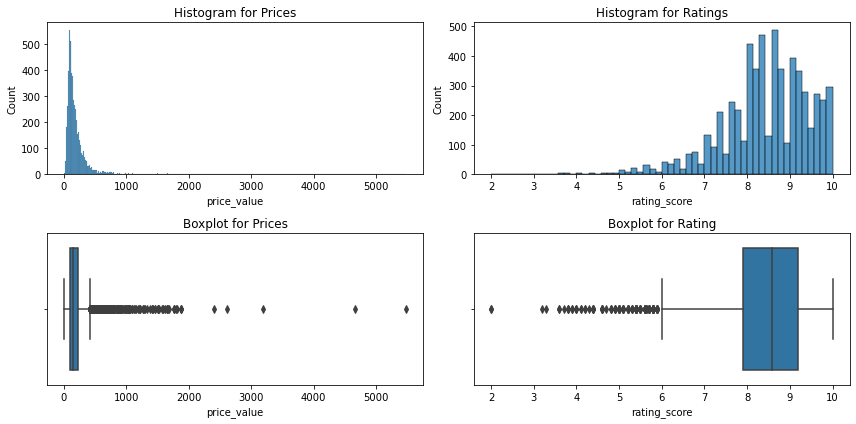

In [46]:
# Create a figure and a grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

# Histogram for price
sns.histplot(data = total_df, x='price_value', ax=axes[0,0])
axes[0,0].set_title("Histogram for Prices")


# Histogram for ratings
sns.histplot(data = total_df, x='rating_score', ax=axes[0,1])
axes[0,1].set_title("Histogram for Ratings")

# Boxplot for price
sns.boxplot(data = total_df, x='price_value', ax=axes[1,0])
axes[1,0].set_title("Boxplot for Prices")

# Boxplot for rating
sns.boxplot(data = total_df, x='rating_score', ax=axes[1,1])
axes[1,1].set_title("Boxplot for Rating")

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()


#### Price Statistics

Price Summary Table for Each City

         count        mean         std   min     25%    50%    75%     max  \
city                                                                         
Berlin  1236.0  114.575243   52.669361  19.0   83.00  105.0  133.0   493.0   
London  1244.0  209.577170  149.708528   9.0  119.00  176.0  259.0  2406.0   
Madrid  1261.0  156.724029  139.906840  25.0   90.00  122.0  181.0  1873.0   
Paris   1216.0  161.075658   90.104580  15.0   99.75  143.0  200.0   747.0   
Rome     935.0  365.571123  401.482556  26.0  127.00  269.0  431.0  5476.0   

        skewness   kurtosis  
city                         
Berlin  2.315873   9.528976  
London  4.229248  42.674609  
Madrid  6.487529  63.049722  
Paris   1.806618   5.839597  
Rome    4.998677  45.906520  



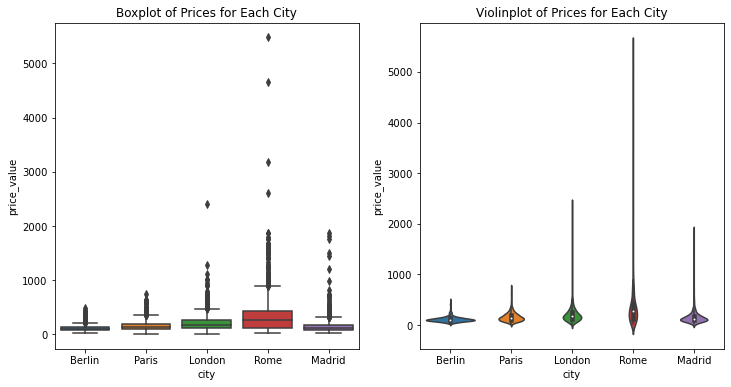

In [144]:
price_city_stats = total_df.groupby('city')['price_value'].describe()
price_city_stats['skewness'] =  total_df.groupby('city')['price_value'].skew()
price_city_stats['kurtosis'] =  total_df.groupby('city')['price_value'].apply(lambda x: pd.Series.kurtosis(x))

print('Price Summary Table for Each City')
print()
print(price_city_stats)
print()

# Create a figure and a grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Boxplot
sns.boxplot(data=total_df, x='city', y='price_value', ax=axes[0])
axes[0].set_title('Boxplot of Prices for Each City')

# Violin Plot
sns.violinplot(data=total_df, x='city', y='price_value', ax=axes[1])
axes[1].set_title('Violinplot of Prices for Each City')
plt.show()



Price Summary for Each Site

              count        mean         std   min    25%    50%    75%  \
site                                                                     
AirBnB       1249.0   90.830264   42.829492  21.0   62.0   85.0  113.0   
Booking.com  2173.0  217.045559  274.454359   9.0  103.0  143.0  223.0   
Hotels.com   2470.0  223.703644  171.396692  19.0  122.0  183.5  268.0   

                max  skewness    kurtosis  
site                                       
AirBnB        629.0  2.567087   21.314002  
Booking.com  5476.0  7.907910  107.926684  
Hotels.com   2406.0  4.099125   29.627700  


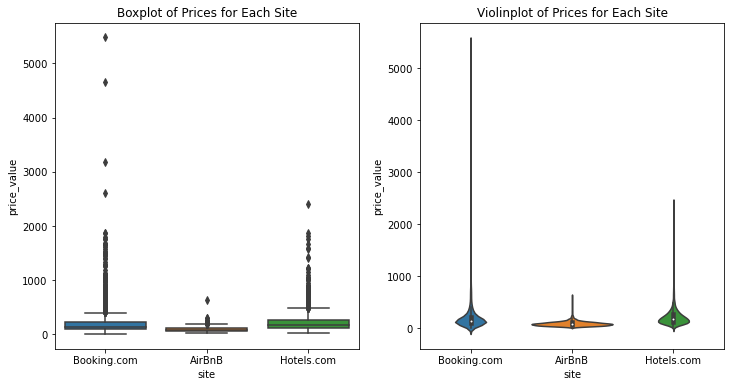

In [145]:
price_site_stats = total_df.groupby('site')['price_value'].describe()
price_site_stats['skewness'] =  total_df.groupby('site')['price_value'].skew()
price_site_stats['kurtosis'] =  total_df.groupby('site')['price_value'].apply(lambda x: pd.Series.kurtosis(x))

print()
print('Price Summary for Each Site')
print()
print(price_site_stats)
# Create a figure and a grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Boxplot
sns.boxplot(data=total_df, x='site', y='price_value', ax=axes[0])
axes[0].set_title('Boxplot of Prices for Each Site')

# Violin Plot
sns.violinplot(data=total_df, x='site', y='price_value', ax=axes[1])
axes[1].set_title('Violinplot of Prices for Each Site')
plt.show()


#### Rating Statistics

Rating Summary for each city

         count      mean       std  min  25%  50%    75%   max  skewness  \
city                                                                       
Berlin  1236.0  8.328414  1.031212  3.6  7.8  8.4  9.000  10.0 -0.672041   
London  1244.0  8.271334  1.107684  3.7  7.6  8.4  9.105  10.0 -0.772410   
Madrid  1261.0  8.556987  0.895569  2.0  8.1  8.6  9.200  10.0 -1.398732   
Paris   1216.0  8.262730  1.085139  3.2  7.6  8.3  9.025  10.0 -0.812802   
Rome     935.0  8.802353  0.935620  2.0  8.4  9.0  9.420  10.0 -1.819576   

        kurtosis  
city              
Berlin  0.821118  
London  0.611031  
Madrid  4.988122  
Paris   1.323768  
Rome    6.529435  


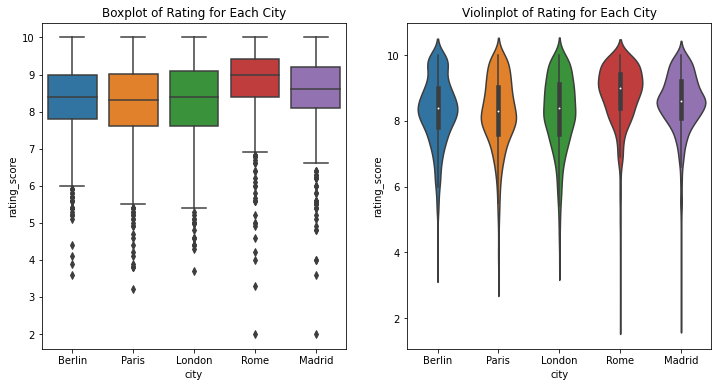

In [146]:
rating_city_stats = total_df.groupby('city')['rating_score'].describe()
rating_city_stats['skewness'] =  total_df.groupby('city')['rating_score'].skew()
rating_city_stats['kurtosis'] =  total_df.groupby('city')['rating_score'].apply(lambda x: pd.Series.kurtosis(x))

print('Rating Summary for each city')
print()
print(rating_city_stats)
# Create a figure and a grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Boxplot
sns.boxplot(data=total_df, x='city', y='rating_score', ax=axes[0])
axes[0].set_title('Boxplot of Rating for Each City')

# Violin Plot
sns.violinplot(data=total_df, x='city', y='rating_score', ax=axes[1])
axes[1].set_title('Violinplot of Rating for Each City')
plt.show()


Rating Summary for Each Site

              count      mean       std   min   25%  50%   75%   max  \
site                                                                   
AirBnB       1249.0  9.493915  0.446838  5.66  9.28  9.6  9.82  10.0   
Booking.com  2173.0  7.859273  0.939276  3.20  7.40  8.0  8.50  10.0   
Hotels.com   2470.0  8.386802  0.907591  2.00  8.00  8.6  9.00  10.0   

             skewness  kurtosis  
site                             
AirBnB      -1.710162  6.147000  
Booking.com -1.231208  2.386343  
Hotels.com  -1.397638  4.002309  


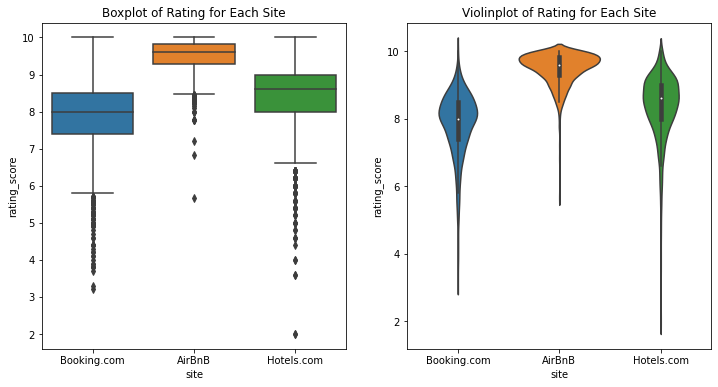

In [147]:
rating_site_stats = total_df.groupby('site')['rating_score'].describe()
rating_site_stats['skewness'] =  total_df.groupby('site')['rating_score'].skew()
rating_site_stats['kurtosis'] =  total_df.groupby('site')['rating_score'].apply(lambda x: pd.Series.kurtosis(x))
print('Rating Summary for Each Site')
print()
print(rating_site_stats)
# Create a figure and a grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Boxplot
sns.boxplot(data=total_df, x='site', y='rating_score', ax=axes[0])
axes[0].set_title('Boxplot of Rating for Each Site')

# Violin Plot
sns.violinplot(data=total_df, x='site', y='rating_score', ax=axes[1])
axes[1].set_title('Violinplot of Rating for Each Site')
plt.show()


### Indentifying Outliers and Removing Them

In [51]:
sorted_price_total_df = total_df.sort_values('price_value', ascending=False)
sorted_price_total_df.head()

,city,price_value,rating_score,site
1577,Rome,5476,8.0,Booking.com
1638,Rome,4653,9.4,Booking.com
1572,Rome,3182,8.4,Booking.com
1470,Rome,2606,9.0,Booking.com
4829,London,2406,8.0,Hotels.com


In [52]:
to_remove = sorted_price_total_df.head().index
refined_total_df = total_df.drop(to_remove, axis=0)

In [53]:
refined_total_df.describe()

,price_value,rating_score
count,5887.000000,5887.000000
mean,190.132835,8.426822
std,178.502111,1.036512
min,9.000000,2.000000
25%,94.000000,7.900000
50%,139.000000,8.580000
75%,221.000000,9.200000
max,1876.000000,10.000000


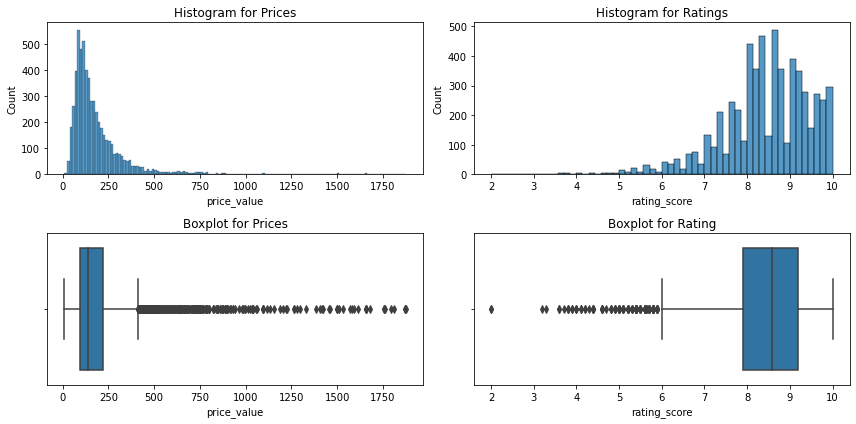

In [54]:
# Create a figure and a grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

# Histogram for price
sns.histplot(data = refined_total_df, x='price_value', ax=axes[0,0])
axes[0,0].set_title("Histogram for Prices")


# Histogram for ratings
sns.histplot(data = refined_total_df, x='rating_score', ax=axes[0,1])
axes[0,1].set_title("Histogram for Ratings")

# Boxplot for price
sns.boxplot(data = refined_total_df, x='price_value', ax=axes[1,0])
axes[1,0].set_title("Boxplot for Prices")

# Boxplot for rating
sns.boxplot(data = refined_total_df, x='rating_score', ax=axes[1,1])
axes[1,1].set_title("Boxplot for Rating")

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()


In [55]:
# Define numeric columns
num_cols = ['price_value']

Q1 = refined_total_df[num_cols].quantile(0.25)
Q3 = refined_total_df[num_cols].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier threshold as 1.5 times the IQR
threshold = 3.5

# Identify outliers in each numeric column
outlier_mask = ((refined_total_df[num_cols] < (Q1 - threshold * IQR)) |
                (refined_total_df[num_cols] > (Q3 + threshold * IQR))).any(axis=1)

# Remove the outliers from the DataFrame
filtered_df = refined_total_df[~outlier_mask]

print("Original DataFrame:")
print(refined_total_df.shape)
print()
print("Filtered DataFrame:")
print(filtered_df.shape)

Original DataFrame:
(5887, 4)

Filtered DataFrame:
(5735, 4)


In [56]:
outliers_df = refined_total_df[outlier_mask]
outliers_df.describe()

,price_value,rating_score
count,152.000000,152.000000
mean,997.236842,8.838816
std,337.360434,0.842422
min,668.000000,5.000000
25%,745.750000,8.600000
50%,863.000000,9.050000
75%,1138.750000,9.400000
max,1876.000000,10.000000


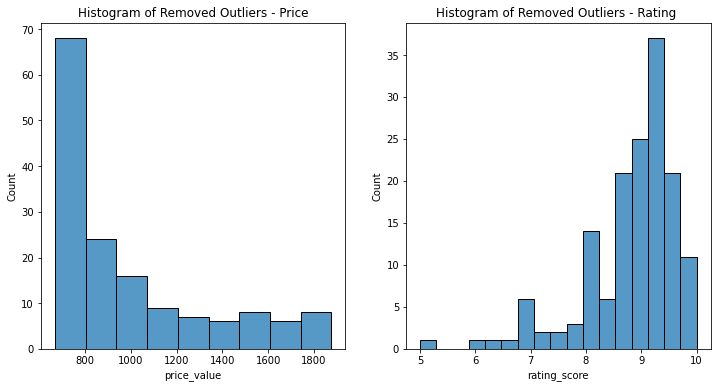

In [57]:
# Create a figure and a grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(data = outliers_df, x='price_value', ax = axes[0])
axes[0].set_title('Histogram of Removed Outliers - Price')
sns.histplot(data = outliers_df, x='rating_score', ax = axes[1])
axes[1].set_title('Histogram of Removed Outliers - Rating ')

plt.show()

### Post-Outlier Removal Analysis

Rating Summary for Each Site

         count      mean       std  min  25%  50%    75%   max  skewness  \
city                                                                       
Berlin  1236.0  8.328414  1.031212  3.6  7.8  8.4  9.000  10.0 -0.672041   
London  1243.0  8.271553  1.108103  3.7  7.6  8.4  9.110  10.0 -0.772737   
Madrid  1261.0  8.556987  0.895569  2.0  8.1  8.6  9.200  10.0 -1.398732   
Paris   1216.0  8.262730  1.085139  3.2  7.6  8.3  9.025  10.0 -0.812802   
Rome     931.0  8.802793  0.936941  2.0  8.4  9.0  9.430  10.0 -1.820642   

        kurtosis  
city              
Berlin  0.821118  
London  0.609086  
Madrid  4.988122  
Paris   1.323768  
Rome    6.519427  


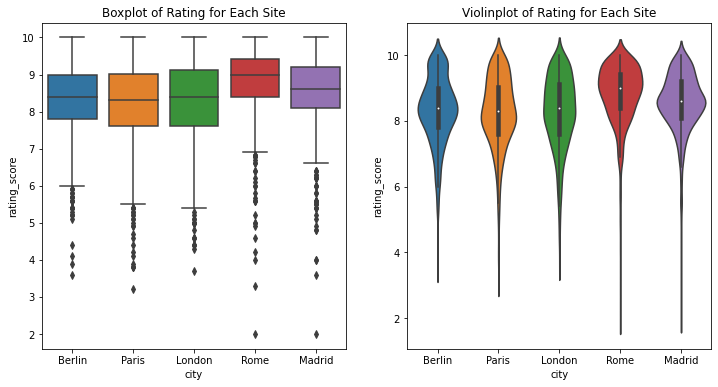

In [150]:
rating_city_stats_new = refined_total_df.groupby('city')['rating_score'].describe()
rating_city_stats_new['skewness'] =  refined_total_df.groupby('city')['rating_score'].skew()
rating_city_stats_new['kurtosis'] =  refined_total_df.groupby('city')['rating_score'].apply(lambda x: pd.Series.kurtosis(x))
print('Rating Summary for Each Site')
print()
print(rating_city_stats_new)
# Create a figure and a grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Boxplot
sns.boxplot(data=refined_total_df, x='city', y='rating_score', ax=axes[0])
axes[0].set_title('Boxplot of Rating for Each Site')

# Violin Plot
sns.violinplot(data=refined_total_df, x='city', y='rating_score', ax=axes[1])
axes[1].set_title('Violinplot of Rating for Each Site')
plt.show()


Rating Summary for Each Site

              count      mean       std   min   25%  50%   75%   max  \
site                                                                   
AirBnB       1249.0  9.493915  0.446838  5.66  9.28  9.6  9.82  10.0   
Booking.com  2169.0  7.857722  0.939163  3.20  7.40  8.0  8.50  10.0   
Hotels.com   2469.0  8.386958  0.907742  2.00  8.00  8.6  9.00  10.0   

             skewness  kurtosis  
site                             
AirBnB      -1.710162  6.147000  
Booking.com -1.231928  2.386352  
Hotels.com  -1.397996  4.001461  


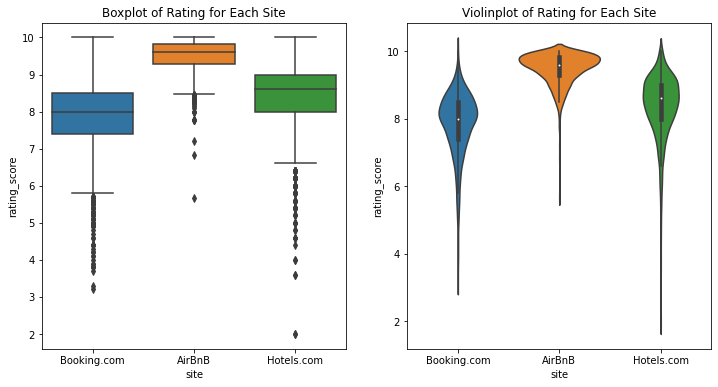

In [148]:
rating_site_stats_new = refined_total_df.groupby('site')['rating_score'].describe()
rating_site_stats_new['skewness'] =  refined_total_df.groupby('site')['rating_score'].skew()
rating_site_stats_new['kurtosis'] =  refined_total_df.groupby('site')['rating_score'].apply(lambda x: pd.Series.kurtosis(x))
print('Rating Summary for Each Site')
print()
print(rating_site_stats_new)
# Create a figure and a grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Boxplot
sns.boxplot(data=refined_total_df, x='site', y='rating_score', ax=axes[0])
axes[0].set_title('Boxplot of Rating for Each Site')

# Violin Plot
sns.violinplot(data=refined_total_df, x='site', y='rating_score', ax=axes[1])
axes[1].set_title('Violinplot of Rating for Each Site')
plt.show()


Price Summary Table for Each City

         count        mean         std   min     25%    50%    75%     max  \
city                                                                         
Berlin  1236.0  114.575243   52.669361  19.0   83.00  105.0  133.0   493.0   
London  1243.0  207.810137  136.173735   9.0  119.00  176.0  259.0  1283.0   
Madrid  1261.0  156.724029  139.906840  25.0   90.00  122.0  181.0  1873.0   
Paris   1216.0  161.075658   90.104580  15.0   99.75  143.0  200.0   747.0   
Rome     931.0  350.045113  316.015299  26.0  127.00  268.0  425.5  1876.0   

        skewness   kurtosis  
city                         
Berlin  2.315873   9.528976  
London  2.279231   9.139419  
Madrid  6.487529  63.049722  
Paris   1.806618   5.839597  
Rome    2.047131   5.122697  



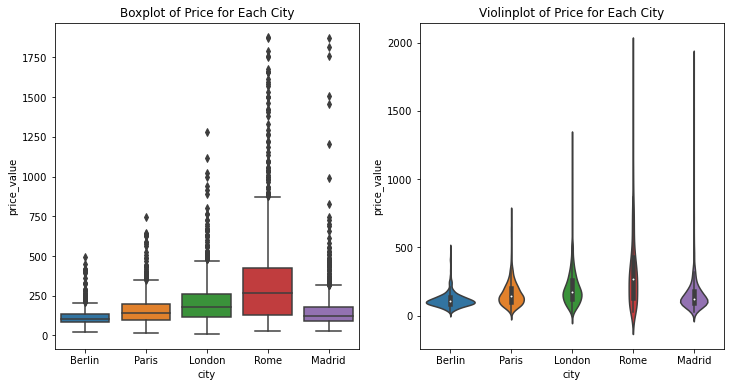

In [137]:
price_city_stats_new = refined_total_df.groupby('city')['price_value'].describe()
price_city_stats_new['skewness'] =  refined_total_df.groupby('city')['price_value'].skew()
price_city_stats_new['kurtosis'] =  refined_total_df.groupby('city')['price_value'].apply(lambda x: pd.Series.kurtosis(x))


print('Price Summary Table for Each City')
print()
print(price_city_stats_new)
print()
# Create a figure and a grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Boxplot
sns.boxplot(data=refined_total_df, x='city', y='price_value', ax=axes[0])
axes[0].set_title('Boxplot of Price for Each City')

# Violin Plot
sns.violinplot(data=refined_total_df, x='city', y='price_value', ax=axes[1])
axes[1].set_title('Violinplot of Price for Each City')
plt.show()


Price Summary Table for Each Site

              count        mean         std   min    25%    50%    75%  \
site                                                                     
AirBnB       1249.0   90.830264   42.829492  21.0   62.0   85.0  113.0   
Booking.com  2169.0  210.107423  216.553814   9.0  103.0  143.0  222.0   
Hotels.com   2469.0  222.819765  165.705403  19.0  122.0  183.0  268.0   

                max  skewness   kurtosis  
site                                      
AirBnB        629.0  2.567087  21.314002  
Booking.com  1876.0  3.838853  18.799164  
Hotels.com   1873.0  3.627745  22.220992  



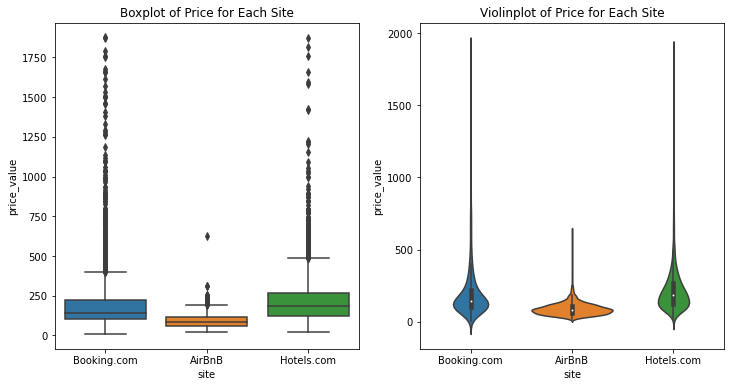

In [138]:
price_site_stats_new = refined_total_df.groupby('site')['price_value'].describe()
price_site_stats_new['skewness'] =  refined_total_df.groupby('site')['price_value'].skew()
price_site_stats_new['kurtosis'] =  refined_total_df.groupby('site')['price_value'].apply(lambda x: pd.Series.kurtosis(x))

print('Price Summary Table for Each Site')
print()
print(price_site_stats_new)
print()
# Create a figure and a grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Boxplot
sns.boxplot(data=refined_total_df, x='site', y='price_value', ax=axes[0])
axes[0].set_title('Boxplot of Price for Each Site')

# Violin Plot
sns.violinplot(data=refined_total_df, x='site', y='price_value', ax=axes[1])
axes[1].set_title('Violinplot of Price for Each Site')
plt.show()

Below I will add rating categories/ranges. Statistically we would like more in the lower categories to properly analyse them but in real life it is probably better that there isn't a lot of hotel ratings that low. 

In [60]:
# Define the rating ranges and corresponding categories
rating_ranges = [(2, 6),(6, 8),(8,10)]
rating_categories = ['2-6','6-8','8-10']

# Create a new column for the rating categories
refined_total_df['rating_category'] = ''

# Iterate through each row and assign the rating category
for i, row in refined_total_df.iterrows():
    rating = row['rating_score']
    for j, (lower, upper) in enumerate(rating_ranges):
        if lower <= rating <= upper:  # Adjusted the comparison operators
            refined_total_df.at[i, 'rating_category'] = rating_categories[j]
            break

Price Summary Table for Each Site

                  count        mean         std   min   25%    50%    75%  \
rating_category                                                             
2-6               175.0  112.502857   91.096253  25.0  69.5   87.0  119.0   
6-8              1678.0  156.000596  124.725963   9.0  93.0  126.0  175.0   
8-10             4034.0  207.698314  196.522679  19.0  98.0  150.0  250.0   

                    max  skewness   kurtosis  
rating_category                               
2-6               839.0  4.654758  29.845061  
6-8              1657.0  5.301053  43.881089  
8-10             1876.0  3.707341  20.004984  



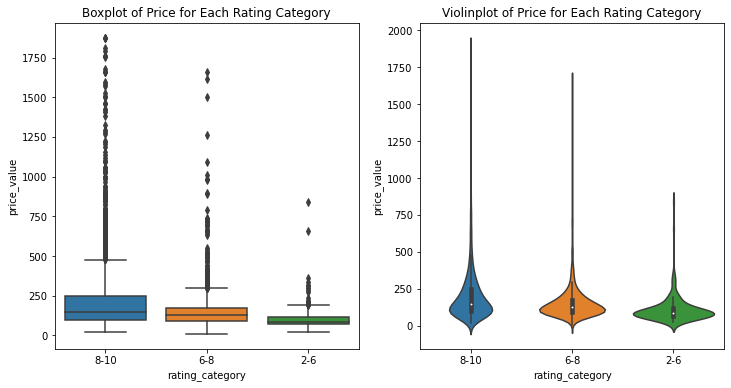

In [140]:
rating_cat_stats = refined_total_df.groupby('rating_category')['price_value'].describe()
rating_cat_stats['skewness'] =  refined_total_df.groupby('rating_category')['price_value'].skew()
rating_cat_stats['kurtosis'] =  refined_total_df.groupby('rating_category')['price_value'].apply(lambda x: pd.Series.kurtosis(x))


print('Price Summary Table for Each Site')
print()
print(rating_cat_stats)
print()
# Create a figure and a grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Boxplot
sns.boxplot(data=refined_total_df, x='rating_category', y='price_value', ax=axes[0])
axes[0].set_title('Boxplot of Price for Each Rating Category')

# Violin Plot
sns.violinplot(data=refined_total_df, x='rating_category', y='price_value', ax=axes[1])
axes[1].set_title('Violinplot of Price for Each Rating Category')
plt.show()

### Analyse Potential Relationships

In [141]:
print(refined_total_df.describe())

       price_value  rating_score
count  5887.000000   5887.000000
mean    190.132835      8.426822
std     178.502111      1.036512
min       9.000000      2.000000
25%      94.000000      7.900000
50%     139.000000      8.580000
75%     221.000000      9.200000
max    1876.000000     10.000000


In [142]:
print(refined_total_df.corr())

              price_value  rating_score
price_value      1.000000      0.114704
rating_score     0.114704      1.000000


#### Linear Regression

In [64]:
# Price predicting Rating
# Create the dependent variable (y) and independent variables (X)
y = refined_total_df['price_value']
X = refined_total_df['rating_score']

# Add a constant column to the independent variables
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X)
results = model.fit()

In [151]:
# Rating predicting Price
# Create the dependent variable (y) and independent variables (X)
y2 = refined_total_df['rating_score']
X2 = refined_total_df['price_value']

# Add a constant column to the independent variables
X2 = sm.add_constant(X2)

# Fit the linear regression model
model2 = sm.OLS(y2, X2)
results2 = model2.fit()

Assumptions for Rating Predicting Price

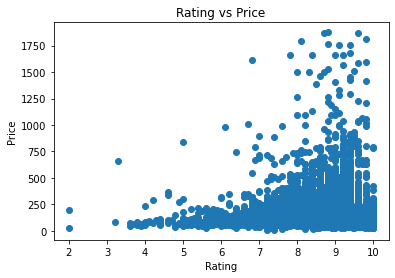

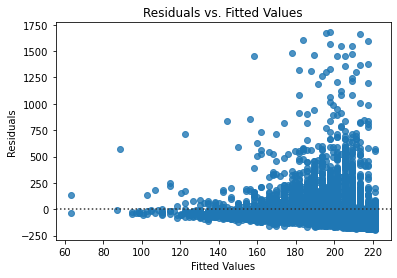

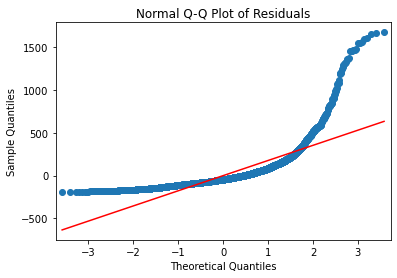

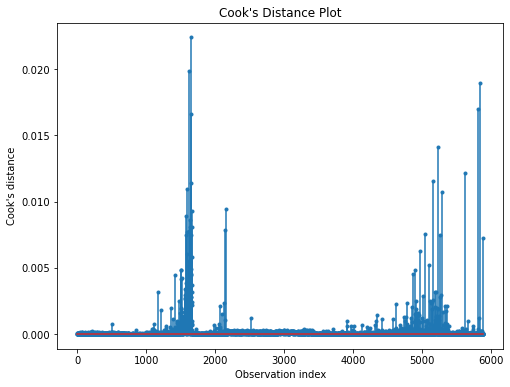

In [65]:
# Rating vs Price
plt.scatter(refined_total_df['rating_score'], y)
plt.xlabel('Rating')
plt.ylabel('Price')
plt.title('Rating vs Price')
plt.show()

# Residuals vs. Fitted values plot and Homoscedasticity
sns.residplot(x=results.fittedvalues, y=results.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

# Normality of residuals
sm.qqplot(results.resid, line='s')
plt.title('Normal Q-Q Plot of Residuals')
plt.show()

# Cook's Distance
influence = results.get_influence()
cooks_distance = influence.cooks_distance[0]
# Plot Cook's distance
plt.figure(figsize=(8, 6))
plt.stem(np.arange(len(cooks_distance)), cooks_distance, markerfmt=".")
plt.xlabel('Observation index')
plt.ylabel("Cook's distance")
plt.title("Cook's Distance Plot")
plt.show()

In [160]:
# Print the summary of the regression results
print('Rating predicting Price')
print(results.summary())

Rating predicting Price
                            OLS Regression Results                            
Dep. Variable:            price_value   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     78.46
Date:                Tue, 11 Jul 2023   Prob (F-statistic):           1.06e-18
Time:                        15:56:39   Log-Likelihood:                -38836.
No. Observations:                5887   AIC:                         7.768e+04
Df Residuals:                    5885   BIC:                         7.769e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           23.6721 

Log-transform the dependent variable(price) and re-do the regression and then compare

In [162]:
# Create the dependent variable (y) and independent variables (X)
y_log = np.log(refined_total_df['price_value'])

# Fit the linear regression model
model_log = sm.OLS(y_log, X)
results_log = model_log.fit()

Assumptions

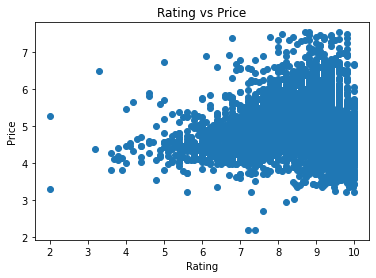

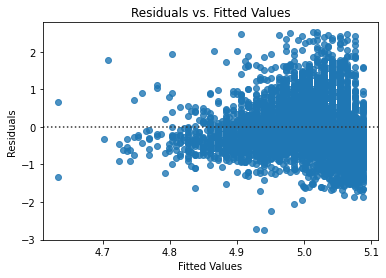

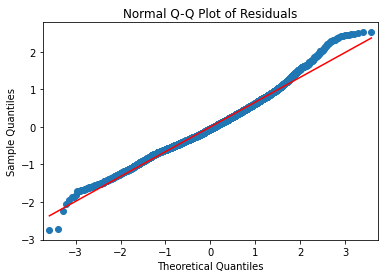

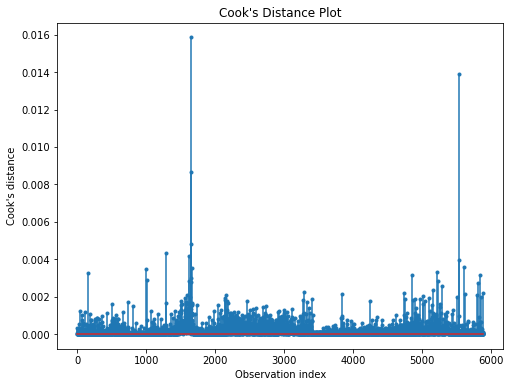

In [169]:
# Rating vs Price
plt.scatter(refined_total_df['rating_score'], y_log)
plt.xlabel('Rating')
plt.ylabel('Price')
plt.title('Rating vs Price')
plt.show()

# Residuals vs. Fitted values plot and Homoscedasticity
sns.residplot(x=results_log.fittedvalues, y=results_log.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

# Normality of residuals
sm.qqplot(results_log.resid, line='s')
plt.title('Normal Q-Q Plot of Residuals')
plt.show()

# Cook's Distance
influence_log = results_log.get_influence()
cooks_distance_log = influence_log.cooks_distance[0]
# Plot Cook's distance
plt.figure(figsize=(8, 6))
plt.stem(np.arange(len(cooks_distance1)), cooks_distance1, markerfmt=".")
plt.xlabel('Observation index')
plt.ylabel("Cook's distance")
plt.title("Cook's Distance Plot")
plt.show()

In [166]:
# Print the summary of the regression results
print(results_log.summary())

                            OLS Regression Results                            
Dep. Variable:            price_value   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     46.71
Date:                Tue, 11 Jul 2023   Prob (F-statistic):           9.07e-12
Time:                        15:59:51   Log-Likelihood:                -5912.2
No. Observations:                5887   AIC:                         1.183e+04
Df Residuals:                    5885   BIC:                         1.184e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.5195      0.071     64.071   

In [167]:
aic1 = results.aic
aic2 = results_log.aic

bic1 = results.bic
bic2 = results_log.bic

if aic1 < aic2:
    print("Model 1 has a lower AIC and is preferred.")
elif aic2 < aic1:
    print("Model 2 has a lower AIC and is preferred.")
else:
    print("Both models have the same AIC.")

if bic1 < bic2:
    print("Model 1 has a lower BIC and is preferred.")
elif bic2 < bic1:
    print("Model 2 has a lower BIC and is preferred.")
else:
    print("Both models have the same BIC.")

Model 2 has a lower AIC and is preferred.
Model 2 has a lower BIC and is preferred.


Testing if the data is normal and if the variances are equal. This is to decide whether we use ANOVA or Kruskal-Wallis tests. 

In [87]:
city_groups = refined_total_df['city'].unique()

for group in city_groups:
    data = refined_total_df.loc[refined_total_df['city'] == group, 'price_value'] 
    
    # Shapiro-Wilk Test
    statistic_sh, p_value_sh = stats.shapiro(data)
    
    # Levene's Test
    data_groups = [refined_total_df.loc[refined_total_df['city'] == g, 'price_value'] for g in city_groups]
    statistic_lev, p_value_lev = stats.levene(*data_groups)
    
    print(f"Group: {group}")
    print("Shapiro-Wilk Test")
    print(f"Test Statistic: {statistic_sh}")
    print(f"P-value: {p_value_sh}")
    print()
    print("Levene's Test")
    print(f"Test Statistic: {statistic_lev}")
    print(f"P-value: {p_value_lev}")
    print()

Group: Berlin
Shapiro-Wilk Test
Test Statistic: 0.8324781656265259
P-value: 4.066549238272777e-34

Levene's Test
Test Statistic: 270.285184933378
P-value: 1.391848127189661e-213

Group: Paris
Shapiro-Wilk Test
Test Statistic: 0.875939130783081
P-value: 4.831337829450249e-30

Levene's Test
Test Statistic: 270.285184933378
P-value: 1.391848127189661e-213

Group: London
Shapiro-Wilk Test
Test Statistic: 0.8295026421546936
P-value: 1.9627812331080338e-34

Levene's Test
Test Statistic: 270.285184933378
P-value: 1.391848127189661e-213

Group: Rome
Shapiro-Wilk Test
Test Statistic: 0.7980267405509949
P-value: 1.779319497153597e-32

Levene's Test
Test Statistic: 270.285184933378
P-value: 1.391848127189661e-213

Group: Madrid
Shapiro-Wilk Test
Test Statistic: 0.5337957739830017
P-value: 0.0

Levene's Test
Test Statistic: 270.285184933378
P-value: 1.391848127189661e-213



In [89]:
site_groups = refined_total_df['site'].unique()

for group in site_groups:
    data = refined_total_df.loc[refined_total_df['site'] == group, 'price_value'] 
    
    # Shapiro-Wilk Test
    statistic_sh, p_value_sh = stats.shapiro(data)
    
    # Levene's Test
    data_groups = [refined_total_df.loc[refined_total_df['site'] == g, 'price_value'] for g in site_groups]
    statistic_lev, p_value_lev = stats.levene(*data_groups)
    
    print(f"Group: {group}")
    print("Shapiro-Wilk Test")
    print(f"Test Statistic: {statistic_sh}")
    print(f"P-value: {p_value_sh}")
    print()
    print("Levene's Test")
    print(f"Test Statistic: {statistic_lev}")
    print(f"P-value: {p_value_lev}")
    print()

Group: Booking.com
Shapiro-Wilk Test
Test Statistic: 0.5878348350524902
P-value: 0.0

Levene's Test
Test Statistic: 118.63735418853081
P-value: 3.077485158649065e-51

Group: AirBnB
Shapiro-Wilk Test
Test Statistic: 0.8635069727897644
P-value: 1.313726138809494e-31

Levene's Test
Test Statistic: 118.63735418853081
P-value: 3.077485158649065e-51

Group: Hotels.com
Shapiro-Wilk Test
Test Statistic: 0.7077808976173401
P-value: 0.0

Levene's Test
Test Statistic: 118.63735418853081
P-value: 3.077485158649065e-51



In [91]:
rating_groups = refined_total_df['rating_category'].unique()

for group in rating_groups:
    data = refined_total_df.loc[refined_total_df['rating_category'] == group, 'price_value'] 
    
    # Shapiro-Wilk Test
    statistic_sh, p_value_sh = stats.shapiro(data)
    
    # Levene's Test
    data_groups = [refined_total_df.loc[refined_total_df['rating_category'] == g, 'price_value'] for g in rating_groups]
    statistic_lev, p_value_lev = stats.levene(*data_groups)
    
    print(f"Group: {group}")
    print("Shapiro-Wilk Test")
    print(f"Test Statistic: {statistic_sh}")
    print(f"P-value: {p_value_sh}")
    print()
    print("Levene's Test")
    print(f"Test Statistic: {statistic_lev}")
    print(f"P-value: {p_value_lev}")
    print()

Group: 8-10
Shapiro-Wilk Test
Test Statistic: 0.6593838334083557
P-value: 0.0

Levene's Test
Test Statistic: 64.9813356659885
P-value: 1.2193140012490917e-28

Group: 6-8
Shapiro-Wilk Test
Test Statistic: 0.5817923545837402
P-value: 0.0

Levene's Test
Test Statistic: 64.9813356659885
P-value: 1.2193140012490917e-28

Group: 2-6
Shapiro-Wilk Test
Test Statistic: 0.5750277042388916
P-value: 1.5164370974572208e-20

Levene's Test
Test Statistic: 64.9813356659885
P-value: 1.2193140012490917e-28



Perform Kruskal-Wallis

In [120]:
data_groups_city = []
medians_city = []
means_city = []
for group in city_groups:
    data = refined_total_df.loc[refined_total_df['city'] == group, 'price_value']
    data_groups_city.append(data)
    medians_city.append(np.median(data))
    means_city.append(np.mean(data))

# Kruskal-Wallis Test
statistic_kw_city, p_value_kw_city = stats.kruskal(*data_groups_city)
# Perform Dunn's test
dunn_results_city = sp.posthoc_dunn(refined_total_df, val_col='price_value', group_col='city')

print("Kruskal-Wallis Test")
print(f"Test Statistic: {statistic_kw_city}")
print(f"P-value: {p_value_kw_city}")
print()
# Print medians
print("Medians:")
for i, group in enumerate(city_groups):
    print(f"{group}: {medians_city[i]}")
print()
print("Means:")
for i, group in enumerate(city_groups):
    print(f"{group}: {means_city[i]}")
# Print Dunn's test results
print()
print("Dunn's Test Results:")
print(dunn_results_city)

Kruskal-Wallis Test
Test Statistic: 913.7131559146592
P-value: 1.7800763488767162e-196

Medians:
Berlin: 105.0
Paris: 143.0
London: 176.0
Rome: 268.0
Madrid: 122.0

Means:
Berlin: 114.5752427184466
Paris: 161.07565789473685
London: 207.81013676588898
Rome: 350.0451127819549
Madrid: 156.7240285487708

Dunn's Test Results:
               Berlin         London        Madrid         Paris  \
Berlin   1.000000e+00  3.626956e-104  5.601562e-20  4.008370e-40   
London  3.626956e-104   1.000000e+00  1.690554e-36  9.771639e-17   
Madrid   5.601562e-20   1.690554e-36  1.000000e+00  2.547371e-05   
Paris    4.008370e-40   9.771639e-17  2.547371e-05  1.000000e+00   
Rome    7.055876e-163   9.117748e-13  3.813794e-79  1.382722e-49   

                 Rome  
Berlin  7.055876e-163  
London   9.117748e-13  
Madrid   3.813794e-79  
Paris    1.382722e-49  
Rome     1.000000e+00  


In [121]:
data_groups_site = []
medians_site = []
means_site = []
for group in site_groups:
    data = refined_total_df.loc[refined_total_df['site'] == group, 'price_value']
    data_groups_site.append(data)
    medians_site.append(np.median(data))
    means_site.append(np.mean(data))

# Kruskal-Wallis Test
statistic_kw_site, p_value_kw_site = stats.kruskal(*data_groups_site)

# Perform Dunn's test
dunn_results_site = sp.posthoc_dunn(refined_total_df, val_col='price_value', group_col='site')

print("Kruskal-Wallis Test")
print(f"Test Statistic: {statistic_kw_site}")
print(f"P-value: {p_value_kw_site}")
print()
# Print medians
print("Medians:")
for i, group in enumerate(site_groups):
    print(f"{group}: {medians_site[i]}")
print()
print("Means:")
for i, group in enumerate(site_groups):
    print(f"{group}: {means_site[i]}")
# Print Dunn's test results
print()
print("Dunn's Test Results:")
print(dunn_results_site)

Kruskal-Wallis Test
Test Statistic: 1477.3727162325563
P-value: 0.0

Medians:
Booking.com: 143.0
AirBnB: 85.0
Hotels.com: 183.0

Means:
Booking.com: 210.10742277547257
AirBnB: 90.8302642113691
Hotels.com: 222.8197650870798

Dunn's Test Results:
                    AirBnB    Booking.com    Hotels.com
AirBnB        1.000000e+00  6.307698e-182  0.000000e+00
Booking.com  6.307698e-182   1.000000e+00  2.042670e-24
Hotels.com    0.000000e+00   2.042670e-24  1.000000e+00


In [122]:
data_groups_rating = []
medians_rating = []
means_rating = []
for group in rating_groups:
    data = refined_total_df.loc[refined_total_df['rating_category'] == group, 'price_value']
    data_groups_rating.append(data)
    medians_rating.append(np.median(data))
    means_rating.append(np.mean(data))

# Kruskal-Wallis Test
statistic_kw_rating, p_value_kw_rating = stats.kruskal(*data_groups_rating)

# Perform Dunn's test
dunn_results_rating = sp.posthoc_dunn(refined_total_df, val_col='price_value', group_col='rating_category')

print("Kruskal-Wallis Test")
print(f"Test Statistic: {statistic_kw_rating}")
print(f"P-value: {p_value_kw_rating}")
print()
# Print medians
print("Medians:")
for i, group in enumerate(rating_groups):
    print(f"Group {group}: {medians_rating[i]}")
print()
print("Means:")
for i, group in enumerate(rating_groups):
    print(f"Group {group}: {means_rating[i]}")
# Print Dunn's test results
print()
print("Dunn's Test Results:")
print(dunn_results_rating)

Kruskal-Wallis Test
Test Statistic: 187.7763102338069
P-value: 1.6783878101482043e-41

Medians:
Group 8-10: 150.0
Group 6-8: 126.0
Group 2-6: 87.0

Means:
Group 8-10: 207.69831432821022
Group 6-8: 156.0005959475566
Group 2-6: 112.50285714285714

Dunn's Test Results:
               2-6           6-8          8-10
2-6   1.000000e+00  4.725847e-13  5.423189e-28
6-8   4.725847e-13  1.000000e+00  6.855938e-21
8-10  5.423189e-28  6.855938e-21  1.000000e+00
